### Importing required libraries

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision #provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
EPOCH = 10
BATCH_SIZE = 32

In [3]:
mnist_train_set = torchvision.datasets.MNIST(
            root='./try1',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )

In [4]:
# trying the sum of 60000 random integers with labels of train dataset of mnist
sum_labels = mnist_train_set.targets + torch.randint(0, 9, (1, 60000)).squeeze()
sum_labels
# torch.stack((mnist_train_set.targets, sum_labels), dim=1)

tensor([ 9,  4,  9,  ...,  9, 10, 10])

In [5]:
sample = next(iter(mnist_train_set))
image, label = sample
image.dtype

torch.float32

label: 5


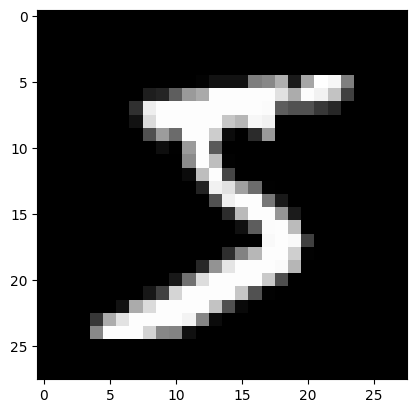

In [6]:
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [7]:
len(mnist_train_set.data)

60000

In [8]:
rn = torch.randint(0, 9, (1, 60000)).squeeze()
rn[1]

tensor(3)

#### Converting sum_labels into binary represatation tensors 

In [9]:
def to_binary(num):
    binary = torch.zeros((5,), dtype=torch.float32)
    i = 0
    while(num != 0):
        if num % 2 == 1:
            binary[i] = 1.0
        num = torch.div(num, 2, rounding_mode='trunc')
        i +=1
    ones = (binary == 1.0).sum(dim=0)
    
    if ones == 2:
        binary /= 2.0
    if ones == 3:
        binary /= 3.0
    if ones == 4:
        binary /= 4.0

    return binary

to_binary(13)

tensor([0.3333, 0.0000, 0.3333, 0.3333, 0.0000])

In [10]:
class MNISTWithNumbers(Dataset):

    def __init__(self):

        self.mnist_data = torchvision.datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )

        self.random_numbers = torch.randint(0, 9, (1, len(self.mnist_data.targets))).squeeze()
        self.numbers = torch.zeros((len(self.mnist_data.targets), 10))
        for i in range(len(self.mnist_data.targets)):
            self.numbers[i][self.random_numbers[i]] = 1


    def __getitem__(self, index):

        sample = self.mnist_data[index]
        image = sample[0]
        label = torch.tensor(sample[1])
        number = self.numbers[index]
        sum_ = label + self.random_numbers[index]
        sum_label = to_binary(sum_)
        
        return image, label, number, sum_label

    def __len__(self):
        return len(self.mnist_data.data)
    
    @property
    def train_labels(self):
        
        sum_labels = self.mnist_data.targets + self.random_numbers
        return self.mnist_data.targets, sum_labels


In [11]:
mnist_with_numbers = MNISTWithNumbers()

In [12]:
targets, sum_labels = mnist_with_numbers.train_labels
targets.shape, sum_labels.shape

(torch.Size([60000]), torch.Size([60000]))

In [13]:
sample = next(iter(mnist_with_numbers))
image, label, number, sum_label = sample
image.shape, label.shape, number.shape, sum_label.shape

(torch.Size([1, 28, 28]), torch.Size([]), torch.Size([10]), torch.Size([5]))

In [14]:
number, sum_label, label

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 tensor([0.0000, 0.0000, 0.5000, 0.5000, 0.0000]),
 tensor(5))

In [15]:
train_data_loader = torch.utils.data.DataLoader(
    mnist_with_numbers,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [16]:
batch = next(iter(train_data_loader))
images, labels, numbers, sum_labels = batch
images.shape, labels.shape, numbers.shape, sum_labels.shape

(torch.Size([32, 1, 28, 28]),
 torch.Size([32]),
 torch.Size([32, 10]),
 torch.Size([32, 5]))

In [17]:
class Network(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1600, out_features=120)
        self.fc2 = nn.Linear(in_features=130, out_features=60)
        self.out1 = nn.Linear(in_features=60, out_features=10)
        self.fc3 = nn.Linear(in_features=60, out_features=30)
        self.out2 = nn.Linear(in_features=30, out_features=5)

    def forward(self, t1, t2):
        # input layer
        x1 = t1
        x2 = t2

        # conv1 layer
        x1 = self.conv1(x1) # 28 | 26
        x1 = F.relu(x1)

        # conv2 layer
        x1 = self.conv2(x1) # 26 | 24
        x1 = F.relu(x1)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2) # 24 | 12
        
        # conv3 layer
        x1 = self.conv3(x1) # 12 | 10
        x1 = F.relu(x1)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2) # 10 | 5

        # flattening the tensor till dimension 1 and keeping the batches
        x1 = x1.flatten(1) # 64 * 5 * 5 = 1600

        # fc1 layer
        x1 = self.fc1(x1) # 1600 | 120
        x1 = F.relu(x1)

        # concatenating the random number
        x = torch.cat((x1, x2), 1) # 120 + 10 

        # fc2 layer 
        x = self.fc2(x) # 130 | 60
        x = F.relu(x)

        #  out1 layer
        out1 = self.out1(x) # 60 | 10
        out1 = F.softmax(out1, dim=1)

        # fc3 layer
        out2 = self.fc3(x) # 60 | 30
        out2 = F.relu(out2)

        # out2 layer

        out2 = self.out2(out2) # 30 | 5
        out2 = F.softmax(out2, dim=1)

        return out1, out2


In [18]:
network = Network()

In [19]:
out1, out2 = network(image.unsqueeze(0), number.unsqueeze(0))
out1, out2

(tensor([[0.1034, 0.1092, 0.0930, 0.0977, 0.0919, 0.0984, 0.0965, 0.1170, 0.0966,
          0.0962]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.2169, 0.2209, 0.1900, 0.1934, 0.1788]], grad_fn=<SoftmaxBackward0>))

In [20]:
sum_labels[sum_labels > 0] = 1
sum_labels

out1, out2 = network(images, numbers)
n = sum_labels[0].eq(1.).sum().item()
_, indices = torch.topk(out2[0], n)
print(out2[0])
out2[0][indices] = 1.
out2[0][out2[0] < 1] = 0.
out2[0], sum_labels[0], torch.all(out2[0].eq(sum_labels[0]))

tensor([0.2162, 0.2222, 0.1890, 0.1918, 0.1807], grad_fn=<SelectBackward0>)


(tensor([0., 1., 0., 0., 0.], grad_fn=<SelectBackward0>),
 tensor([0., 0., 1., 0., 0.]),
 tensor(False))

In [21]:
def get_preds_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def get_preds_sum_correct(preds, labels, batch_size):
    count = 0
    labels[labels > 0] = 1.
    for i in range(batch_size):
        n =  labels[i].eq(1.).sum().item()
        if n > 0:
            _, index = torch.topk(preds[i], n)
            preds[i][index] = 1.
    preds[preds<1] = 0.
    for i in range(batch_size):
        if torch.all(labels[i].eq(preds[i])):
            count += 1
    return count

In [22]:
get_preds_correct(out1, labels), get_preds_sum_correct(out2, sum_labels, 32)

(3, 5)

### Testing if everything is working fine

In [23]:
import torch.optim as optim

mnist_with_numbers = MNISTWithNumbers()

train_loader = torch.utils.data.DataLoader(
    mnist_with_numbers,
    batch_size=BATCH_SIZE,
    shuffle=True
)

network = Network()

optimizer = optim.Adam(network.parameters(), lr=0.001)

batch = next(iter(train_loader)) #get batch
images, labels, numbers, sum_labels = batch
pred_labels, pred_sums = network(images, numbers)
loss_image = F.cross_entropy(pred_labels, labels) # calculating loss for image
loss_sum = F.cross_entropy(pred_sums, sum_labels) # calculating loss for sum

loss_image.backward(retain_graph=True) #calculate gradients
loss_sum.backward()
optimizer.step() #update weights

print('loss1:', loss_image.item(), loss_sum.item())
pred_labels, pred_sums = network(images, numbers)
loss_image = F.cross_entropy(pred_labels, labels) 
loss_sum = F.cross_entropy(pred_sums, sum_labels)
print('loss2:',loss_image.item(), loss_sum.item())

loss1: 2.30411434173584 1.6114611625671387
loss2: 2.3027780055999756 1.6108030080795288


In [24]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)

In [25]:
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.001)
# network.to(device)

for epoch in range(EPOCH):
    
    total_correct_MNIST = 0
    total_correct_sum = 0
    total_loss_MNIST = 0
    total_loss_sum = 0
    total_size = 0

    for batch in train_loader:
        images, labels, numbers, sum_labels = batch
        # images, labels, numbers, sum_labels = images.to(device), labels.to(device), numbers.to(device), sum_labels.to(device)
        pred_images, pred_sums = network(images, numbers)
        loss_image = F.cross_entropy(pred_images, labels) # calculating loss for image
        loss_sum = F.cross_entropy(pred_sums, sum_labels) # calculating loss for sum

        optimizer.zero_grad() # set the grads to zero 
        loss_image.backward(retain_graph=True)
        loss_sum.backward()
        optimizer.step() # update weights

        total_loss_MNIST += loss_image.item()
        total_correct_MNIST += get_preds_correct(pred_images, labels)
        total_loss_sum += loss_sum.item()
        total_correct_sum += get_preds_sum_correct(pred_sums, sum_labels, len(sum_labels))
        total_size += len(images)

    print(f'epoch: {epoch} \n \t MNIST: total loss: {total_loss_MNIST: .2f} acc: {total_correct_MNIST/total_size*100: .2f} \n \t Addition: total loss: {total_loss_sum: .2f} acc: {total_correct_sum/total_size*100: .2f}')

epoch: 0 
 	 MNIST: total loss:  2944.36 acc:  89.31 
 	 Addition: total loss:  2846.33 acc:  32.66
epoch: 1 
 	 MNIST: total loss:  2778.54 acc:  98.18 
 	 Addition: total loss:  2609.16 acc:  45.44
epoch: 2 
 	 MNIST: total loss:  2765.88 acc:  98.69 
 	 Addition: total loss:  2521.40 acc:  49.19
epoch: 3 
 	 MNIST: total loss:  2761.25 acc:  98.92 
 	 Addition: total loss:  2513.80 acc:  50.85
epoch: 4 
 	 MNIST: total loss:  2757.53 acc:  99.11 
 	 Addition: total loss:  2509.43 acc:  53.93
epoch: 5 
 	 MNIST: total loss:  2754.99 acc:  99.23 
 	 Addition: total loss:  2502.90 acc:  56.85
epoch: 6 
 	 MNIST: total loss:  2752.99 acc:  99.34 
 	 Addition: total loss:  2488.48 acc:  60.85
epoch: 7 
 	 MNIST: total loss:  2752.35 acc:  99.36 
 	 Addition: total loss:  2471.57 acc:  64.22
epoch: 8 
 	 MNIST: total loss:  2750.29 acc:  99.47 
 	 Addition: total loss:  2459.22 acc:  67.44
epoch: 9 
 	 MNIST: total loss:  2749.69 acc:  99.49 
 	 Addition: total loss:  2451.55 acc:  71.82
